In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os, sys
import xarray as xr 
import pandas as pd
import psycopg2
import geopandas as gpd

# adds the package path to the Python path to make sure all the local imports work fine 
if os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))) not in sys.path:
    sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))

# local imports 
from wp4.constants import POLLUTANTS, DATA_DIR_CAMS_AN, DATA_DIR_CAMS_RE, DATA_DIR_PLOTS, DB_NAME, DB_USER, DB_PASS, DB_HOST

In [2]:
# Initiate connection to the database
conn = psycopg2.connect(dbname=DB_NAME, user=DB_USER, password=DB_PASS, host=DB_HOST)
# Set up the query to extract all the information per pixel coordinate from the database, leaving out no data pixels
query = f"""
            SELECT
            id,
            ST_X(geometry),
            ST_Y(geometry),
            corine_grid_code,
            corine_label_3,
            elevation_avg,
            slope_avg
            FROM public.spatial_baseline_info
            WHERE
            spatial_baseline_info.corine_grid_code NOT IN (128) 
        """
# store the result as a pandas dataframe
df_info = pd.read_sql_query(query, con=conn).rename(columns={'st_x': 'longitude', 'st_y': 'latitude'})
# close the connection to the database
conn.close()

df_info = df_info[df_info['corine_grid_code'] != 44]
df_info = df_info.astype({
    'longitude':'float32',
    'latitude':'float32',
}).round({'longitude':2, 'latitude':2})
DF_INFO = df_info.set_index(['latitude', 'longitude'])

In [3]:
def get_weekday_name(x):
    
    days = ["Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"]
    
    return days[x.weekday()]

def get_weekday(x):
    return x.weekday()

def get_hour(x):
    return int(x.strftime('%H'))

def get_weeknumber(x):
    return int(x.isocalendar()[1])

def get_data_weekday(pollutant):
    
    days = ["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"]
    
    pollutant_var = POLLUTANTS[pollutant]['CAMS']
    
    ds = xr.open_dataset(f'{DATA_DIR_CAMS_RE}/{pollutant}/cams_reanalysis_{pollutant}_2018.nc')
    ds['weekday'] = ds.time.to_pandas().apply(get_weekday)
    ds['weekday_name'] = ds.time.to_pandas().apply(get_weekday_name)
    
    df = ds.to_dataframe()
    df = df.reset_index()
    df = df.astype({
        'longitude':'float32',
        'latitude':'float32',
        pollutant_var:'float32',
        'weekday':'int8',  
    }).round({'longitude':2, 'latitude':2, pollutant_var:2})
    df = df.set_index(['latitude', 'longitude'])
    
    df_land = df.join(DF_INFO, on=['latitude','longitude']).dropna(subset=['corine_grid_code'])
    df_land = df_land.reset_index().round({'longitude':2, 'latitude':2}).set_index(['latitude','longitude'])
    
    groups = df_land.groupby('weekday')
    
    data = [x[1][pollutant_var].values for x in groups]
    labels = [days[x[0]] for x in groups]
    
    return data, labels

def get_data_weeknumber(pollutant):
    
    pollutant_var = POLLUTANTS[pollutant]['CAMS']
    
    ds = xr.open_dataset(f'{DATA_DIR_CAMS_RE}/{pollutant}/cams_reanalysis_{pollutant}_2018.nc')
    ds['weeknumber'] = ds.time.to_pandas().apply(get_weeknumber)
    
    df = ds.to_dataframe()
    df = df.reset_index()
    df = df.astype({
        'longitude':'float32',
        'latitude':'float32',
        pollutant_var:'float32',
        'weeknumber':'int8',  
    }).round({'longitude':2, 'latitude':2, pollutant_var:2})
    df = df.set_index(['latitude', 'longitude'])
    
    df_land = df.join(DF_INFO, on=['latitude','longitude']).dropna(subset=['corine_grid_code'])
    df_land = df_land.reset_index().round({'longitude':2, 'latitude':2}).set_index(['latitude','longitude'])

    groups = df_land.groupby('weeknumber')
    data = [x[1][pollutant_var].values for x in groups]
    labels = [x[0] for x in groups]
    
    return data, labels

def get_data_hour(pollutant):
    
    pollutant_var = POLLUTANTS[pollutant]['CAMS']
    
    ds = xr.open_dataset(f'{DATA_DIR_CAMS_RE}/{pollutant}/cams_reanalysis_{pollutant}_2018.nc')
    ds['hour'] = ds.time.to_pandas().apply(get_hour)
    
    df = ds.to_dataframe()
    df = df.reset_index()
    df = df.astype({
        'longitude':'float32',
        'latitude':'float32',
        pollutant_var:'float32',
        'hour':'int8',  
    }).round({'longitude':2, 'latitude':2, pollutant_var:2})
    df = df.set_index(['latitude', 'longitude'])
    
    df_land = df.join(DF_INFO, on=['latitude','longitude']).dropna(subset=['corine_grid_code'])
    df_land = df_land.reset_index().round({'longitude':2, 'latitude':2}).set_index(['latitude','longitude'])
    
    groups = df_land.groupby('hour')
    
    data = [x[1][pollutant_var].values for x in groups]
    labels = [x[0] for x in groups]
    
    return data, labels

In [4]:
OUTPUT_DIR = Path(DATA_DIR_PLOTS).joinpath('temporal_characteristics')

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

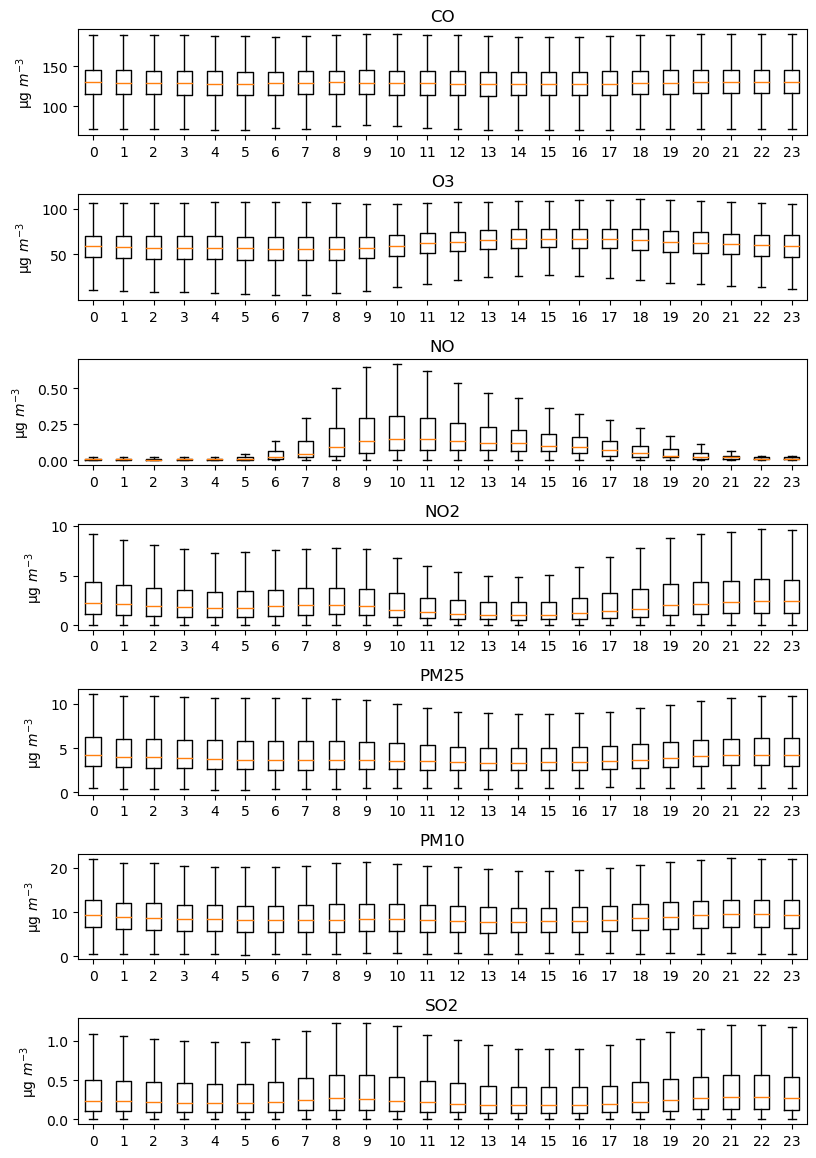

In [5]:
fig, ax = plt.subplots(7,1, figsize=(8.27, 11.69), dpi=100)
# fig.suptitle('CAMS Reanalysis pollutant distribution per hour of the day for Ireland in 2018.')

for ind, pollutant in enumerate(POLLUTANTS):
    data, labels = get_data_hour(pollutant)

    ax[ind].set_title(pollutant)
    ax[ind].boxplot(data, labels=labels, sym="")
    ax[ind].set_ylabel('µg $m^{-3}$')
    
fig.tight_layout()
plt.savefig(OUTPUT_DIR.joinpath('per_hour.png'))
plt.show()

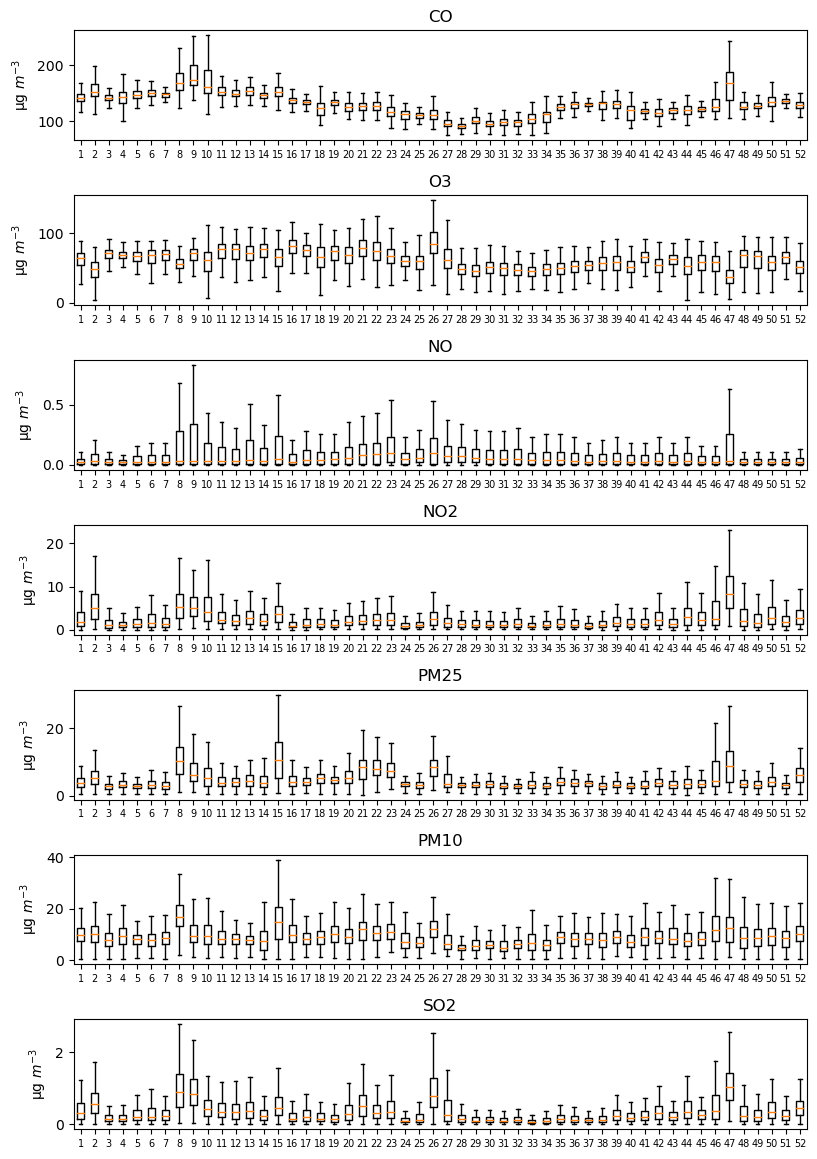

In [6]:
fig, ax = plt.subplots(7,1, figsize=(8.27, 11.69), dpi=100)
# fig.suptitle('CAMS Reanalysis pollutant distribution per week for Ireland in 2018')

for ind, pollutant in enumerate(POLLUTANTS):
    data, labels = get_data_weeknumber(pollutant)

    ax[ind].set_title(pollutant)
    ax[ind].boxplot(data, labels=labels, sym="")
    ax[ind].set_ylabel('µg $m^{-3}$')
    ax[ind].tick_params(axis="x", labelsize=7) 
    
# plt.xticks(fontsize = 8, rotation=30, ha='right')
fig.tight_layout()
plt.savefig(OUTPUT_DIR.joinpath('per_week.png'))
plt.show()

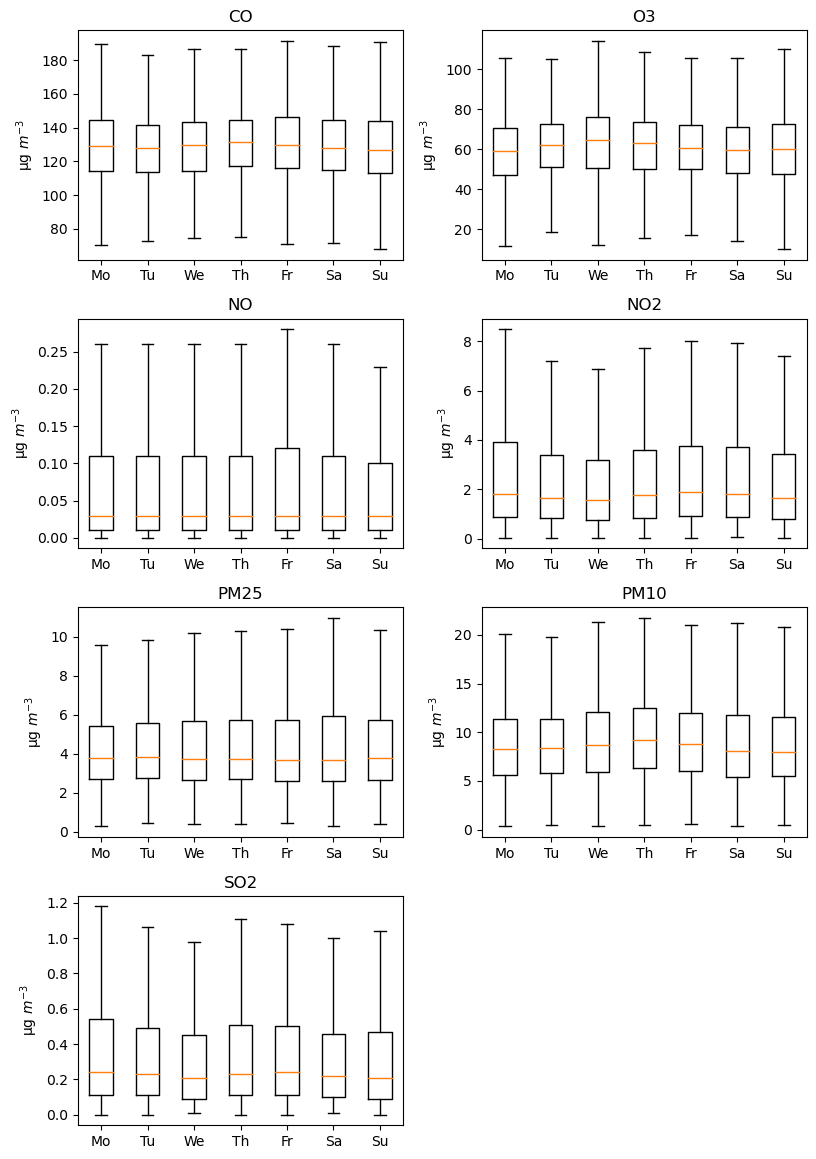

In [8]:
fig, ax = plt.subplots(4,2, figsize=(8.27, 11.69), dpi=100)
# fig.suptitle('CAMS Reanalysis pollutant distribution per weekday for Ireland in 2018)')

positions = {
    0:ax[0][0],
    1:ax[0][1],
    2:ax[1][0],
    3:ax[1][1],
    4:ax[2][0],
    5:ax[2][1],
    6:ax[3][0],
}

for ind, pollutant in enumerate(POLLUTANTS):
    
    data, labels = get_data_weekday(pollutant)

    positions[ind].set_title(pollutant)
    positions[ind].plot(x, y, linewidth=2.0)
    positions[ind].plot(x, y, linewidth=2.0)
    positions[ind].plot(x, y, linewidth=2.0)
    positions[ind].set_ylabel('µg $m^{-3}$')

ax[3][1].set_visible(False)
    
fig.tight_layout()
plt.savefig(OUTPUT_DIR.joinpath('per_weekday.png'))
plt.show()